In [1]:
import ntpath
import os
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import sklearn
import cv2

2023-06-07 14:43:49.372956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
input_shape = (224, 224)
number_of_epochs = 50
'''
train_percentage = 0.7
validation_percentage = 0.2
test_percentage = 0.1
'''
weights_directory = "/Users/andreacivitarese/PycharmProjects/CVandDL/classification/weights"
results_directory = "/Users/andreacivitarese/PycharmProjects/CVandDL/classification/results"
path_dataset_men = "/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/men/"
path_dataset_women = "/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/women/"


In [3]:
# Codice per ottenere il path delle immagini da classificare
imgs_list_men = [os.path.join(path_dataset_men, img_name) for img_name in os.listdir(path_dataset_men)]
imgs_list_women = [os.path.join(path_dataset_women, img_name) for img_name in os.listdir(path_dataset_women)]
imgs_list = imgs_list_men + imgs_list_women

print("Numero totale immagini: " + str(len(imgs_list)))

imgs_array = []
for file_path in imgs_list:
    img = cv2.imread(file_path)
    img = cv2.resize(img, input_shape)
    #RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_array.append(img)

Numero totale immagini: 1373


[[[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 [[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 [[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 ...

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]]
/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/men/51_GUCCI_calf-leather.jpg


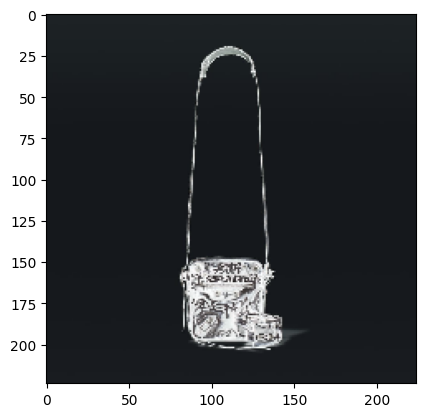

In [4]:
print(imgs_array[0])
print(imgs_list[0])

imgplot = plt.imshow(255-imgs_array[1], vmin=0, vmax=255)

In [5]:
# creazione delle etichette delle immagini
possible_materials = set()
for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    materials = material.split('+')
    for materiale in materials:
        possible_materials.add(materiale.split('.')[0])
list_possible_materials = list(possible_materials)

print("Numero possibili materiali: " + str(len(possible_materials)))
print(list_possible_materials)

labels = []

for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    materials = material.split('+')
    label = np.zeros(shape=len(possible_materials), dtype=float)
    for materiale in materials:
        materiale = materiale.split('.')[0]
        indice = list_possible_materials.index(materiale)
        label[indice] = 1
    labels.append(label)

print(str(len(labels)))

Numero possibili materiali: 22
['lamb-leather', 'recycled-nylon', 'jute', 'brass', 'velvet', 'fabric', 'mercerised-cotton', 'canvas', 'organic-cotton', 'plastic', 'Plexiglas®', 'ethylene-vinyl-acetate', 'raffia', 'palm-leaf', 'goat-leather', 'polyurethane', 'cow-leather', 'polyester', 'lamb-fur', '100%-cotton', 'leather', 'calf-leather']
1373


In [6]:
from sklearn.model_selection import train_test_split

images_array, labels_array = sklearn.utils.shuffle(imgs_array, labels, random_state=15)
Xtrain, X_test, Ytrain, Y_test = train_test_split(images_array,labels_array, test_size=0.10,  random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(Xtrain, Ytrain, test_size=0.2,  random_state=15)

X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)
Y_test = np.asarray(Y_test)

In [7]:
mobilenet_v3 = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

model = tf.keras.Sequential()
model.add(mobilenet_v3)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(22, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 1024)              48169984  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

In [8]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(os.path.join(results_directory, "model.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)
model.compile(loss="categorical_crossentropy", metrics="Recall",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9))

In [9]:
history = model.fit(np.asarray(X_train), np.asarray(Y_train), epochs=number_of_epochs, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1, callbacks=[checkpoint], shuffle=True)

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 4.7054 - recall: 0.8099 - precision: 0.0810
Epoch 00001: val_loss improved from inf to 2.83905, saving model to /Users/andreacivitarese/PycharmProjects/CVandDL/classification/results/model.h5
31/31 [==============================] - 185s 5s/step - loss: 4.7054 - recall: 0.8099 - precision: 0.0810 - val_loss: 2.8391 - val_recall: 0.9264 - val_precision: 0.1328
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 2.8634 - recall: 0.9581 - precision: 0.0967
Epoch 00002: val_loss improved from 2.83905 to 2.19729, saving model to /Users/andreacivitarese/PycharmProjects/CVandDL/classification/results/model.h5
31/31 [==============================] - 159s 5s/step - loss: 2.8634 - recall: 0.9581 - precision: 0.0967 - val_loss: 2.1973 - val_recall: 0.9535 - val_precision: 0.1157
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 2.1622 - recall: 0.9717 - precision: 0.0968
Epoch 00003: val_loss im

KeyboardInterrupt: 